This is the notebook for the analysis of algal blooms using quarterly averages of the cellcount.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
from plotly.offline import plot
import seaborn as sns
from datetime import datetime, timedelta
from pandas.plotting import scatter_matrix
sns.set_style("whitegrid")
#pd.options.mode.chained_assignment = None

In [2]:
# Loading up all data
df= pd.read_csv('habsos_20230714.csv',parse_dates=['SAMPLE_DATE'])

/var/folders/md/dkhh40ls43946rm74g11l2340000gn/T/ipykernel_61504/1109652745.py:2: DtypeWarning:

Columns (18,19,22) have mixed types. Specify dtype option on import or set low_memory=False.



Loading up all the data and focusing on the location `Florida`.

In [3]:
df_FL = df.loc[df.STATE_ID== 'FL']
df_FL = df_FL.dropna(subset=['SALINITY','WATER_TEMP','CELLCOUNT'], how='any').copy()
df_FL = df_FL[['SAMPLE_DATE','CELLCOUNT','WATER_TEMP','SALINITY']]

We then take quarterly averages of of `CELLCOUNT, WATER_TEMP, SALINITY`.

In [4]:
FL_month = df_FL.groupby(pd.Grouper(key='SAMPLE_DATE', freq='M', sort=True )).mean().dropna().reset_index() #taking monthly averages
FL_month['CELLCOUNT_LOG'] = np.log10(FL_month.CELLCOUNT.replace(0,1)) #setting cellcounts that are 0 to 1 so that log does not explode
FL_month.loc[FL_month.CELLCOUNT_LOG < 0,'CELLCOUNT_LOG'] = 0 # setting average cellcounts that are smaller than 1 to zero
FL_month['Year'] = FL_month['SAMPLE_DATE'].dt.year.copy()
FL_month['month_year'] = FL_month['SAMPLE_DATE'].dt.to_period('M')
FL_Q = FL_month.set_index('SAMPLE_DATE').resample('Q', convention='end').agg('mean').to_period(freq ='Q')#finally taking quarter average

Plot of all the data for Florida

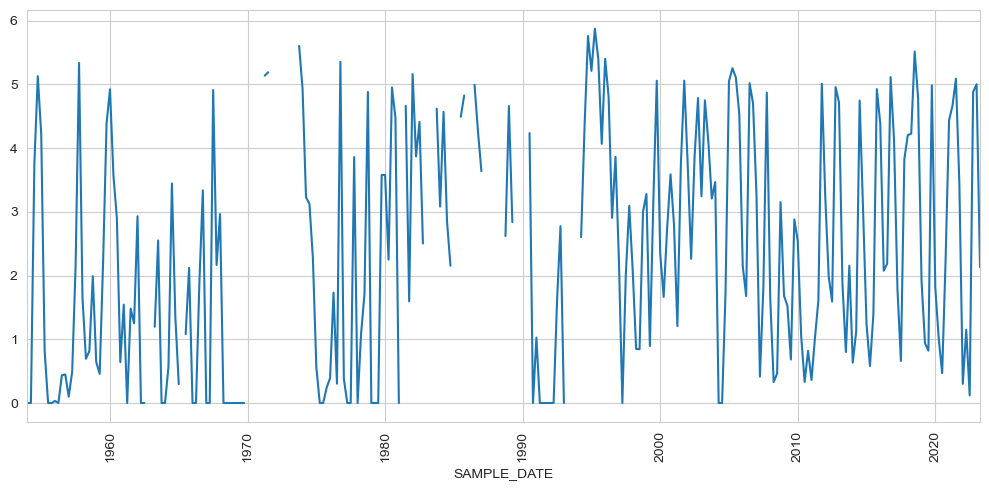

In [5]:
f1 = plt.figure("Quarterly",figsize=(10,5))
ax = plt.subplot(1,1,1)
FL_Q['CELLCOUNT_LOG'].plot.line(ax=ax)
plt.setp(ax.get_xticklabels(), rotation=90)
f1.tight_layout()

Since the data has missing pieces for quarterly averages for the sake of simplicity we will just focus on dates > 1995. This part seems to be complete.

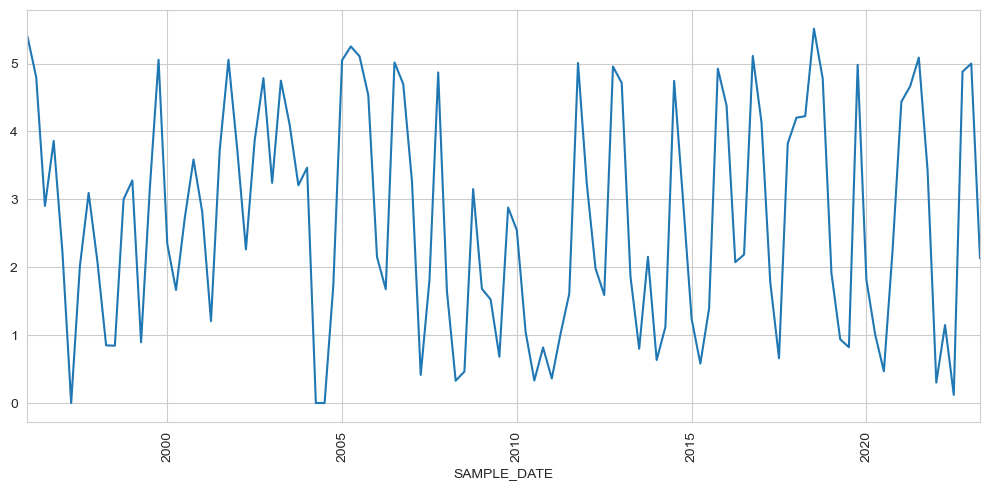

In [6]:
f1 = plt.figure("Quarterly",figsize=(10,5))
ax = plt.subplot(1,1,1)
FL_Q.loc[FL_Q['Year']>1995]['CELLCOUNT_LOG'].plot.line(ax=ax)
plt.setp(ax.get_xticklabels(), rotation=90)
#plt.axis('off')
f1.tight_layout()

In [7]:
FL_short = FL_Q.loc[(FL_Q.Year < 2024)&(FL_Q.Year >1995)]

Now let us check subseasonal plots with their means in order to have an idea about seasonality.

In [8]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss, acf, grangercausalitytests
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf,month_plot,quarter_plot
from scipy import signal
import matplotlib.pyplot as plt
import seaborn as sns

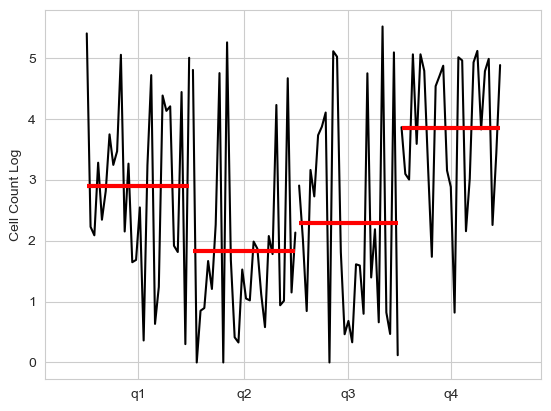

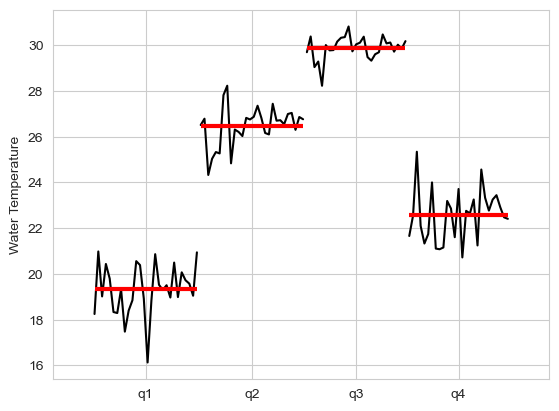

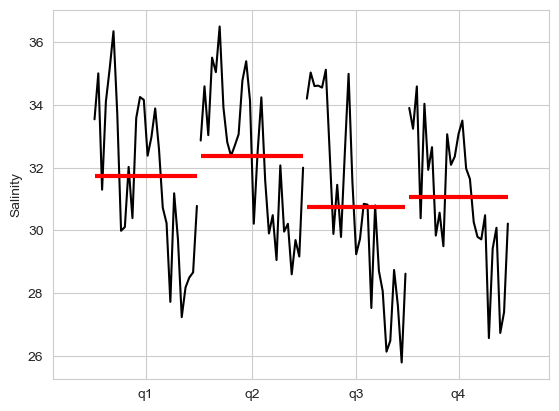

In [9]:
dta = FL_short
fig_cellcount = sm.graphics.tsa.quarter_plot(dta['CELLCOUNT_LOG'],ylabel = 'Cell Count Log')
fig_temperature = sm.graphics.tsa.quarter_plot(dta['WATER_TEMP'],ylabel = 'Water Temperature')
fig_salinity = sm.graphics.tsa.quarter_plot(dta['SALINITY'],ylabel = 'Salinity')


Below are the correlation plots of three variables. Note that unlike spike count vs other features the correlation is low.

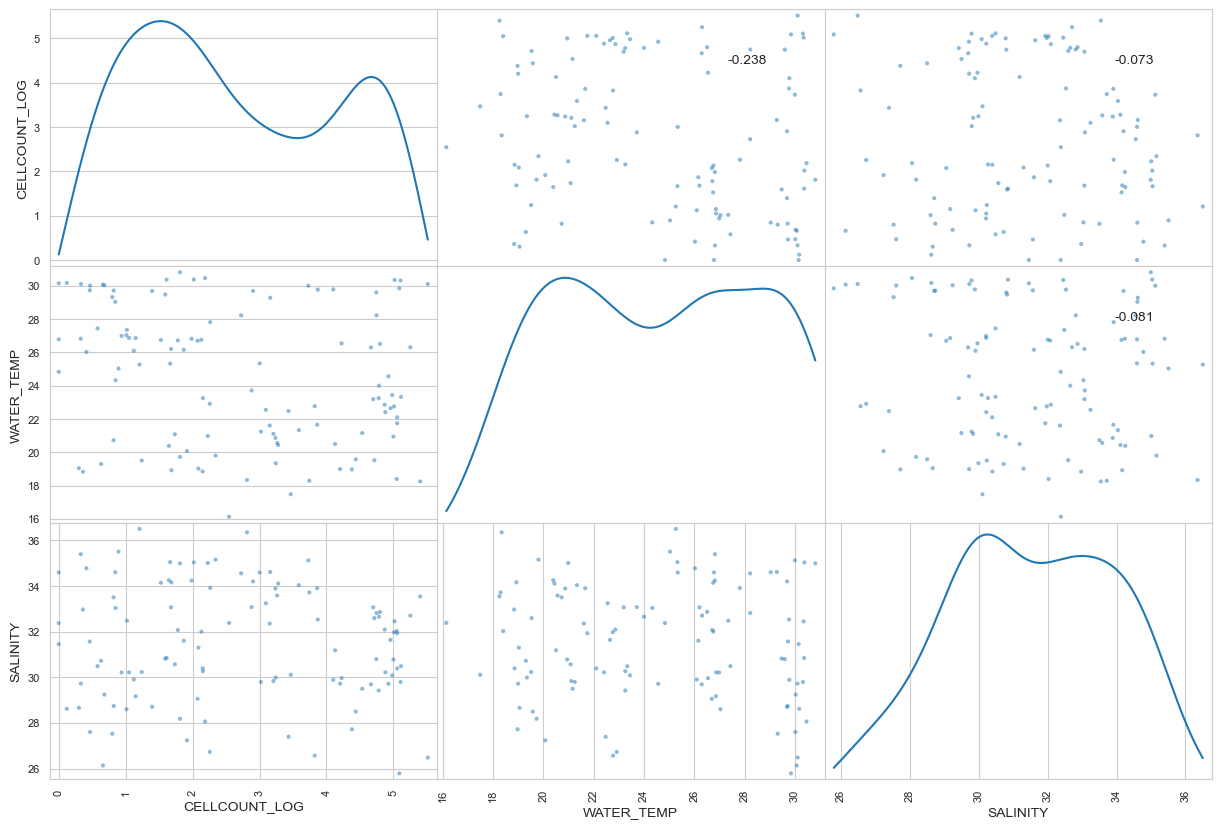

In [10]:
axes = scatter_matrix(FL_short[['CELLCOUNT_LOG','WATER_TEMP','SALINITY']], alpha=0.5,figsize=(15, 10), diagonal='kde')
corr = FL_short[['CELLCOUNT_LOG','WATER_TEMP','SALINITY']].corr().to_numpy()
for i, j in zip(*plt.np.triu_indices_from(axes, k=1)):
    axes[i, j].annotate("%.3f" %corr[i,j], (0.8, 0.8), xycoords='axes fraction', ha='center', va='center')
plt.show()

Lets make a training and test split. We will leave `2020-2023` data as test and the rest as training.

In [11]:
alg_train =  FL_short.loc[FL_short.Year < 2019].copy()
alg_test = FL_short.drop(alg_train.index).copy()
alg_train = alg_train.rename(columns={'CELLCOUNT':'cellcount','CELLCOUNT_LOG':'cellcount_log'})
alg_test = alg_test.rename(columns={'CELLCOUNT':'cellcount','CELLCOUNT_LOG':'cellcount_log'})

Seems like we have a seasonal behaviour so we are going to use the following baseline models:
- The average baseline forecast,
- The seasonal average baseline forecast,
- Naive baseline forecast,
- Seasonal naive baseline forecast,

Below we will compute these baselines.

# Baselines

We now introduce `cross validation ` (cv) sets and compute the `root mean square error ` (rmse) for baseline forecasts.

In [12]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

In [13]:
splits = 10
size = 3
cv = TimeSeriesSplit(splits, 
                     test_size=size)
forecast_y = 8 #forecasting n quarters into the future

### The  Average Forecast

In [14]:
avg_rmses = np.zeros(splits)

i = 0
for train_index, test_index in cv.split(alg_train):
    alg_tt = alg_train.reset_index().loc[train_index] #train set
    alg_ho = alg_train.reset_index().loc[test_index] #holdout set
    
    tt_avg = alg_tt.cellcount_log.mean()
    
    avg_rmses[i] = np.sqrt(mean_squared_error(alg_ho.cellcount_log.values,
                                    tt_avg*np.ones(size)))
    
    i = i + 1
av_base = np.mean(avg_rmses)    

### The Seasonal Average Forecast

In [15]:
savg_rmses = np.zeros(splits)

i = 0

for train_index, test_index in cv.split(alg_train):
    alg_tt = alg_train.iloc[train_index]
    alg_ho = alg_train.iloc[test_index]
    
    quarter_avgs = {}

    for quarter in range(1, 5):
        quarter_avgs[quarter] = alg_tt.reset_index().loc[alg_tt.reset_index().SAMPLE_DATE.dt.quarter == quarter].cellcount_log.mean()

    pred = []
    
    for quarter in alg_ho.reset_index().SAMPLE_DATE.dt.quarter.values:
        pred.append(quarter_avgs[quarter])
        
    savg_rmses[i] = np.sqrt(mean_squared_error(alg_ho.cellcount_log.values, pred))
    i = i + 1
sav_base = np.mean(savg_rmses)    

### The Naive Forecast

In [16]:
naive_rmses = np.zeros(splits)

i = 0
for train_index, test_index in cv.split(alg_train):
    alg_tt = alg_train.reset_index().loc[train_index] #train set
    alg_ho = alg_train.reset_index().loc[test_index] #holdout set
    
    tt_naive = alg_tt.cellcount_log.values[-1]
    
    naive_rmses[i] = np.sqrt(mean_squared_error(alg_ho.cellcount_log.values,
                                    tt_naive*np.ones(size)))
    
    i = i + 1
nav_base = np.mean(naive_rmses)    

### The Sesonal Naive Forecast

In [17]:
snaive_rmses = np.zeros(splits)

i = 0

for train_index, test_index in cv.split(alg_train):
    alg_tt = alg_train.iloc[train_index]
    alg_ho = alg_train.iloc[test_index]
    
    pred = []
    
    for quarter in alg_ho.reset_index().SAMPLE_DATE.dt.quarter.values:
        pred.append(alg_tt.reset_index().loc[alg_tt.reset_index().SAMPLE_DATE.dt.quarter == quarter].cellcount_log.values[-1])
        
    snaive_rmses[i] = np.sqrt(mean_squared_error(alg_ho.cellcount_log.values, pred))
    i = i + 1
snav_base = np.mean(snaive_rmses)    

In [18]:
pd.DataFrame({'Base Model':['Average Base','Sesonal Base','Naive Base','Seasonal Naive']
              , 'RMSE':[av_base,sav_base,nav_base,snav_base]}).style.set_caption(
                  'cv RMSE of the Baselines')

,Base Model,RMSE
0,Average Base,1.628660
1,Sesonal Base,1.355350
2,Naive Base,1.965576
3,Seasonal Naive,1.870055


## Rolling Average

In [19]:
cv = TimeSeriesSplit(splits, test_size=size)

start = 2
end = 35
ra_rmse = np.zeros((splits, len(range(start, end))))


i = 0
for train_index, test_index in cv.split(alg_train):
    alg_tt = alg_train.iloc[train_index]
    alg_ho = alg_train.iloc[test_index]
    
    j = 0
    for q in range(start, end):
        pred = alg_tt.cellcount_log[-q:].mean() * np.ones(len(alg_ho))
        
        ra_rmse[i,j] = np.sqrt(mean_squared_error( alg_ho.cellcount_log.values, pred))
        j = j + 1
    i = i + 1   

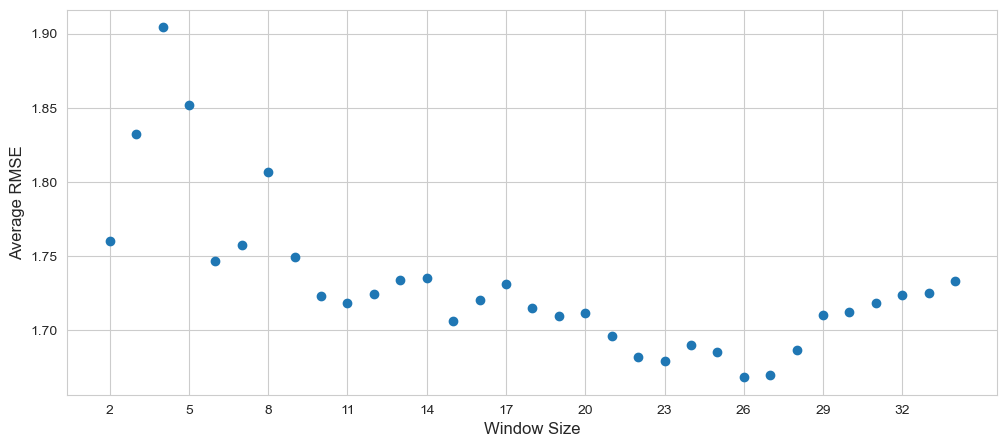

In [20]:
plt.figure(figsize=(12,5))

plt.scatter(range(start,end), np.mean(ra_rmse, axis=0))

plt.xlabel("Window Size", fontsize=12)
plt.ylabel("Average RMSE", fontsize=12)

plt.xticks(range(start, end, 3), fontsize=10)
plt.yticks(fontsize=10)

plt.show()

In [21]:
print("The window size that minimized the avg. cv RMSE",
      "was q =", 
      range(start,end)[np.argmin(np.mean(ra_rmse, axis=0))],
      "\b.",
      "It had a mean cv RMSE of", 
      np.round(np.min(np.mean(ra_rmse, axis=0)), 5))
rolling = np.round(np.min(np.mean(ra_rmse, axis=0)), 5)

The window size that minimized the avg. cv RMSE was q = 26. It had a mean cv RMSE of 1.66845


In [22]:
## Importing the model from statsmodels
from statsmodels.tsa.api import SimpleExpSmoothing

In [23]:
exp_rmse = np.zeros((splits, len(np.arange(0, 0.95, .01))))

i = 0
for train_index, test_index in cv.split(alg_train):
    alg_tt = alg_train.iloc[train_index]
    alg_ho = alg_train.iloc[test_index]
    
    j = 0
    for alpha in np.arange(0, 0.95, .01):
        exp_smooth = SimpleExpSmoothing(alg_tt.cellcount_log.values).fit(smoothing_level=alpha,optimized=False)
        exp_rmse[i,j] = np.sqrt(mean_squared_error( alg_ho.cellcount_log.values, exp_smooth.forecast(len(alg_ho))))
        j = j + 1
    i = i + 1

In [24]:
## This gives us the indices of the smallest
## avg cv rmse
exp_ind = np.argmin(np.mean(exp_rmse, axis=0))

In [25]:
print("The alpha value that give simple exponential",
         "smoothing model with lowest avg cv rmse is",
         "alpha = ", np.arange(0, 0.95, .01)[exp_ind])

print("This model had an avg cv rmse of",
         np.round(np.mean(exp_rmse, axis=0)[exp_ind],5))
exp_mod = np.round(np.mean(exp_rmse, axis=0)[exp_ind],5)

The alpha value that give simple exponential smoothing model with lowest avg cv rmse is alpha =  0.03
This model had an avg cv rmse of 1.6201


In [26]:
## Importing the model from statsmodels
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [27]:
exp_rmse = np.zeros((splits, len(np.arange(0, 0.2, .01)), len(np.arange(0, 0.2, .01))))

i = 0
for train_index, test_index in cv.split(alg_train):
    alg_tt = alg_train.iloc[train_index]
    alg_ho = alg_train.iloc[test_index]
    
    j = 0
    for alpha in np.arange(0, 0.2, .01):
        k = 0
        for beta in np.arange(0, 0.2, .01):
            exp_smooth = ExponentialSmoothing(alg_train.cellcount_log.dropna().values,
                                      seasonal='add',
                                      seasonal_periods= 4).fit(smoothing_level=beta,
                                                                  smoothing_trend=0,
                                                                  smoothing_seasonal=alpha,
                                                                  optimized=False)

            exp_rmse[i,j,k] = np.sqrt(mean_squared_error(alg_ho.cellcount_log.values, exp_smooth.forecast(len(alg_ho))))
            k = k + 1
        j = j + 1
    i = i + 1

In [28]:
## This gives us the indices of the smallest
## avg cv rmse
exp_ind = np.unravel_index(np.argmin(np.mean(exp_rmse, axis=0), axis=None), 
                           np.mean(exp_rmse, axis=0).shape)
np.unravel_index(np.argmin(np.mean(exp_rmse, axis=0), axis=None), 
                 np.mean(exp_rmse, axis=0).shape)

(19, 4)

In [29]:
print("The alpha and beta values that give a double exponential",
         "smoothing model with lowest avg cv rmse are",
         "alpha = ", np.arange(0, 0.2, .01)[exp_ind[0]],
         "and beta = ", np.arange(0, 0.2, .01)[exp_ind[1]])

print("This model had an avg cv rmse of",
         np.round(np.mean(exp_rmse, axis=0)[exp_ind],3))

exp3_mod = np.round(np.mean(exp_rmse, axis=0)[exp_ind],5)

The alpha and beta values that give a double exponential smoothing model with lowest avg cv rmse are alpha =  0.19 and beta =  0.04
This model had an avg cv rmse of 1.618


## ACF Plots

For the stationary check of the data we use ACF plots below.

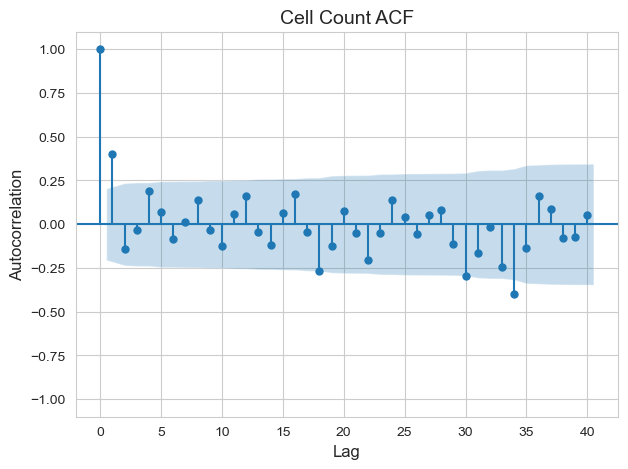

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(7,5))

sm.graphics.tsa.plot_acf(alg_train.cellcount_log,
                            lags = 40,
                            ax = ax)

plt.title('Cell Count ACF', fontsize=14)
plt.ylabel("Autocorrelation", fontsize=12)
plt.xlabel("Lag", fontsize=12)

plt.ylim(-1.1,1.1)

plt.show()

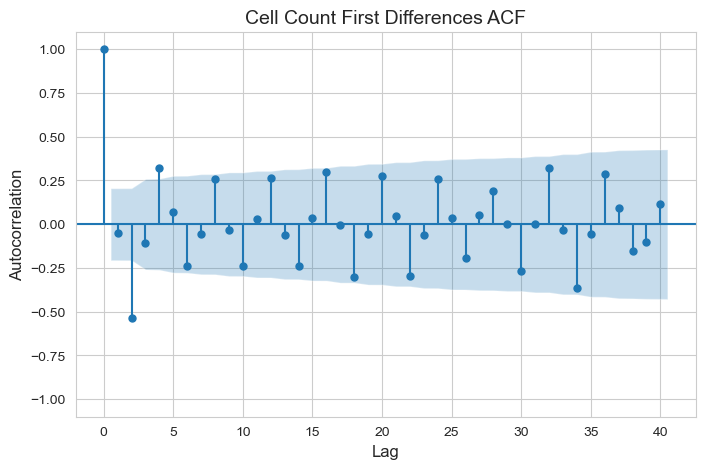

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(8,5))

sm.graphics.tsa.plot_acf(alg_train.cellcount_log.diff(periods = 1).values[1:],
                               lags=40,
                               ax=ax)

plt.title('Cell Count First Differences ACF', fontsize=14)
plt.ylabel("Autocorrelation", fontsize=12)
plt.xlabel("Lag", fontsize=12)

plt.ylim(-1.1,1.1)

plt.show()

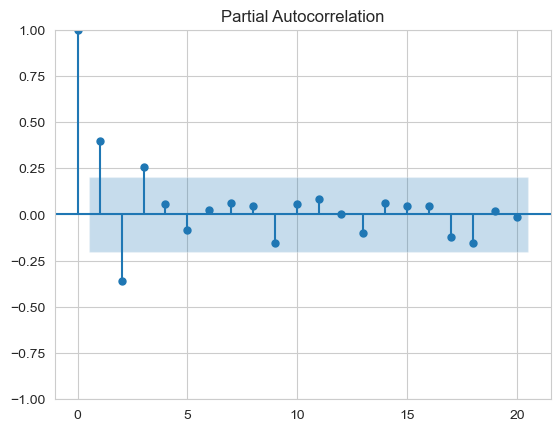

In [32]:
sm.graphics.tsa.plot_pacf(alg_train.cellcount_log, lags=20)
plt.show()

From the ACF plots we will consider $D=1$ and a seasonality $m=4$. We feed in these values to the automatic order selection tool that uses  [Akaike Information Criterion (AIC)] and try to find rest of the parameters.

In [33]:
from statsmodels.tsa.api import ARIMA
from pmdarima import auto_arima

In [34]:
auto_arima(alg_train.cellcount_log.values, trace=True, seasonal=True,D=1,m=4)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[4] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(0,0,0)(0,1,0)[4] intercept   : AIC=377.853, Time=0.00 sec
 ARIMA(1,0,0)(1,1,0)[4] intercept   : AIC=340.089, Time=0.02 sec
 ARIMA(0,0,1)(0,1,1)[4] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,0,0)(0,1,0)[4]             : AIC=375.861, Time=0.00 sec
 ARIMA(1,0,0)(0,1,0)[4] intercept   : AIC=357.045, Time=0.01 sec
 ARIMA(1,0,0)(2,1,0)[4] intercept   : AIC=331.544, Time=0.03 sec
 ARIMA(1,0,0)(2,1,1)[4] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(1,0,0)(1,1,1)[4] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,0,0)(2,1,0)[4] intercept   : AIC=353.575, Time=0.02 sec
 ARIMA(2,0,0)(2,1,0)[4] intercept   : AIC=323.945, Time=0.03 sec
 ARIMA(2,0,0)(1,1,0)[4] intercept   : AIC=331.310, Time=0.03 sec
 ARIMA(2,0,0)(2,1,1)[4] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(2,0,0)(1,1,1)[4] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(3,0,0)(2,1,0)[4] intercept   : AIC=325.940, Time=0.04 sec
 ARIMA

ARIMA(order=(2, 0, 0), scoring_args={}, seasonal_order=(2, 1, 0, 4),
      suppress_warnings=True, with_intercept=False)

Although we have found the parameters ARIMA(2,0,0)(2,1,0)[4] from AIC, we found out that the set 
ARIMA(1,0,0)(0,1,1)[4] works better.

In [35]:
sarima_rmses_auto = np.zeros(splits)

i = 0
for train_index, test_index in cv.split(alg_train):

    alg_tt = alg_train.iloc[train_index]
    alg_ho = alg_train.iloc[test_index]
    sarima = ARIMA(alg_tt.cellcount_log.values,
                               order=(1, 0, 0),seasonal_order = (0,1,1,4)).fit()
    sarima_rmses_auto[i] = np.sqrt(mean_squared_error(alg_ho.cellcount_log.values,  sarima.forecast(len(alg_ho))))
            
    i = i +1
sar_mod = sarima_rmses_auto.mean()
print("The SARIMA model an avg cv rmse of", sar_mod)      

The SARIMA model an avg cv rmse of 1.20685513763758


In [36]:
sarima_plot = ARIMA(alg_train.cellcount_log.values,
                    order = (1,0,0),
                    seasonal_order = (0,1,1,4)).fit()

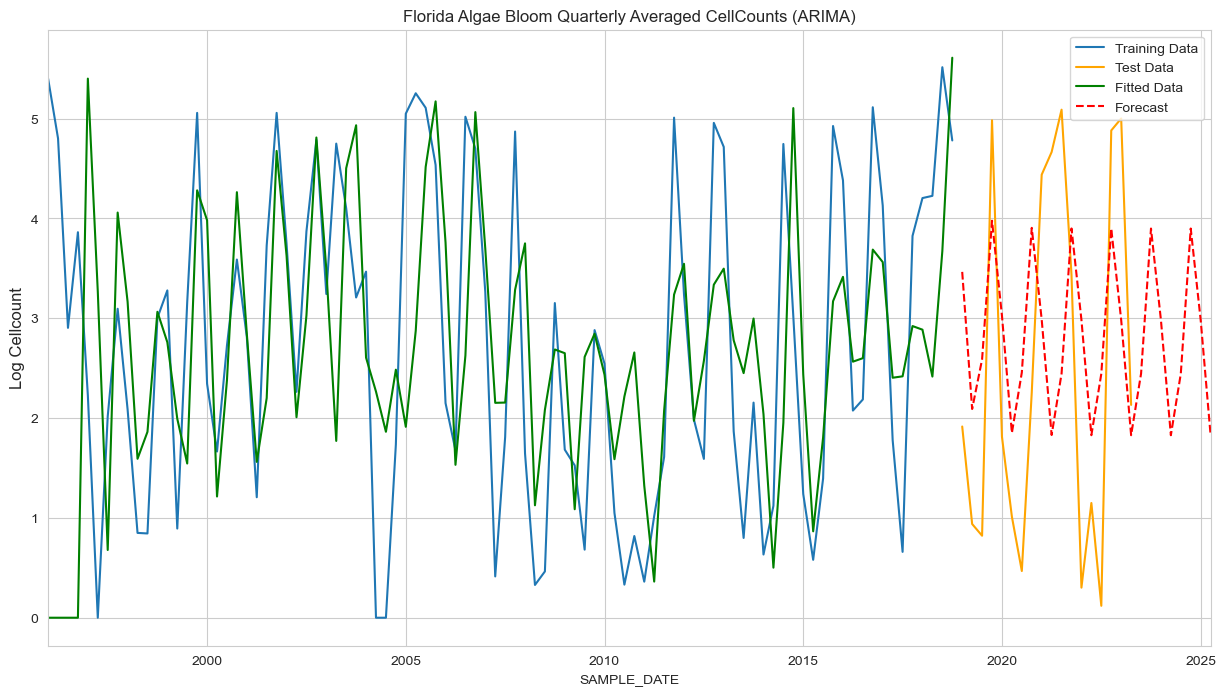

In [37]:
sar_train = pd.DataFrame(
   sarima_plot.fittedvalues, columns=['Sarima Fitted Values'],
    index=pd.period_range(alg_train.index.min(), periods=len(alg_train), freq='Q'))

sar_forecast = pd.DataFrame(
   sarima_plot.forecast(len(alg_test)+forecast_y), columns=['Sarima Forecast'],
    index=pd.period_range(alg_test.index.min(), periods=len(alg_test)+forecast_y, freq='Q'))
fig, ax = plt.subplots()
alg_train['cellcount_log'].plot.line(figsize=(15,8),style = '-',ax=ax)
alg_test['cellcount_log'].plot(style = '-',ax=ax, color = 'orange',label ='Test')
sar_train.plot(style = '-',ax=ax, color = 'green')
sar_forecast.plot(style = '--',ax=ax,color = 'red')
ax.legend(["Training Data", "Test Data",'Fitted Data','Forecast'])
plt.title('Florida Algae Bloom Quarterly Averaged CellCounts (ARIMA)')
plt.ylabel("Log Cellcount", fontsize=12)
plt.show()

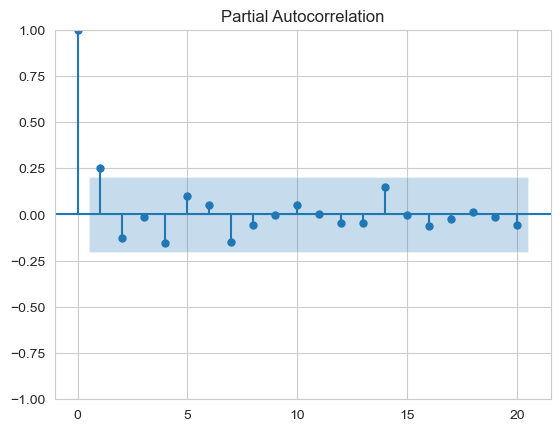

In [38]:
plot_pacf(alg_train.cellcount_log -  sarima_plot.fittedvalues)
plt.show()

In [39]:
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error, r2_score

import math
from dateutil.relativedelta import relativedelta
from datetime import datetime, date

In [40]:
rf_rmses_auto = np.zeros(splits)

i = 0
for train_index, test_index in cv.split(alg_train):

    alg_tt = alg_train.iloc[train_index]
    alg_ho = alg_train.iloc[test_index]
    RF_Model = RandomForestRegressor(n_estimators=80,
                                 max_features=1, oob_score=True)
    rf = RF_Model.fit(alg_tt.WATER_TEMP.values.reshape(-1, 1), alg_tt.cellcount_log.values)
    rf_rmses_auto[i] = np.sqrt(mean_squared_error(alg_ho.cellcount_log.values,  rf.predict(alg_ho.WATER_TEMP.values.reshape(-1, 1))))
            
    i = i +1
rf_mod = np.mean(rf_rmses_auto)    

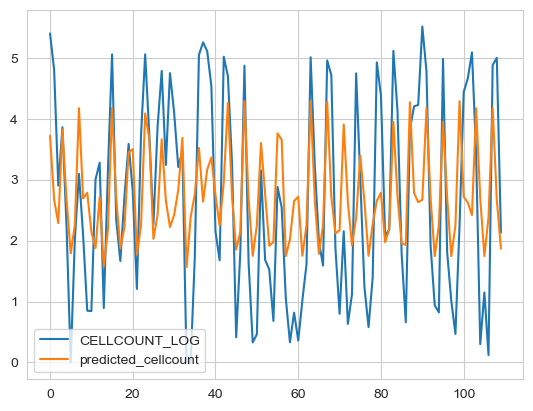

In [41]:
RF_Model = RandomForestRegressor(max_depth=3, n_estimators=1000,
                                 max_features=1,min_samples_leaf = 1,random_state = 216, oob_score=True)
labels = alg_train.reset_index().cellcount_log
features = alg_train.reset_index().WATER_TEMP
rgr = RF_Model.fit(features.values.reshape(-1, 1), labels.values)
X_test_predict = pd.DataFrame(
    rgr.predict(alg_test.WATER_TEMP.values.reshape(-1, 1))).rename(
    columns={0:'predicted_cellcount'}).set_index('predicted_cellcount')
X_train_predict = pd.DataFrame(
    rgr.predict(alg_train.WATER_TEMP.values.reshape(-1, 1))).rename(
    columns={0:'predicted_cellcount'}).set_index('predicted_cellcount')
RF_predict = X_train_predict._append(X_test_predict)
wtemp = FL_short.reset_index().join((RF_predict.reset_index()))
wtemp[['CELLCOUNT_LOG', 'predicted_cellcount']].plot()
plt.show()

## The Final Results

In [42]:
pd.DataFrame({'Base Model':['Average Base','Sesonal Base','Naive Base','Seasonal Naive']
              , 'RMSE':[av_base,sav_base,nav_base,snav_base]}).style.set_caption(
                  'cv RMSE of the Baselines')

,Base Model,RMSE
0,Average Base,1.628660
1,Sesonal Base,1.355350
2,Naive Base,1.965576
3,Seasonal Naive,1.870055


In [43]:
pd.DataFrame({'Model':['Rolling Average','Exponential Smoothing','ARIMA','Random Forest (Temp)']
              , 'cv RMSE':[rolling,exp_mod,sar_mod,rf_mod]}).style.set_caption(
                  'cv RMSE of the Models')

,Model,cv RMSE
0,Rolling Average,1.668450
1,Exponential Smoothing,1.620100
2,ARIMA,1.206855
3,Random Forest (Temp),1.748257
